# Prepare dataset

## Gdrive setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os

project_root = '/content/drive/MyDrive/game_AI_project'
data_root = project_root + '/data'
vid_root = data_root + '/videos'
mask_root = data_root + '/masks'
annotations_file_train = data_root + '/annotations_train.txt'
annotations_file_val = data_root + '/annotations_val.txt'
annotations_file_test = data_root + '/annotations_test.txt'
style_root = data_root + '/style'
style_class_dir = style_root + '/all'
checkpoints_root = project_root + '/checkpoints'
sample_output_root = project_root + '/sample_output'

for dir in [project_root, data_root, vid_root, mask_root, style_root, style_class_dir, checkpoints_root, sample_output_root]:
    try:
        os.mkdir(dir)
    except OSError as error:
        print(error)

[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/videos'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/masks'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/style'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/data/style/all'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/checkpoints'
[Errno 17] File exists: '/content/drive/MyDrive/game_AI_project/sample_output'


## get video_dataset.py

In [3]:
!rm -rf Video-Dataset-Loading-Pytorch*

In [4]:
!git clone https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch.git

Cloning into 'Video-Dataset-Loading-Pytorch'...
remote: Enumerating objects: 411, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 411 (delta 72), reused 53 (delta 53), pack-reused 328
Receiving objects: 100% (411/411), 6.70 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [5]:
!cp Video-Dataset-Loading-Pytorch/video_dataset.py ./video_dataset.py

## Download and unzip DAVIS dataset [Not required if already present on mounted google drive]

In [ ]:
!git clone https://github.com/davisvideochallenge/davis-2017.git

In [ ]:
!davis-2017/data/get_davis.sh

### Copy data to Google drive, only if required

In [ ]:
#remove dirs where num frames do not match
import os
import os.path as path
vid_path = '/content/DAVIS/JPEGImages/480p'
mask_path = '/content/DAVIS/Annotations/480p'
annotations = []
for f in os.listdir(vid_path):
    if len(os.listdir(path.join(vid_path, f))) != len(os.listdir(path.join(mask_path, f))) or len(os.listdir(path.join(mask_path, f))) == 0:
        print('removing ', f)
        for g in os.listdir(path.join(vid_path, f)):
            os.remove(path.join(vid_path, f, g))
        for g in os.listdir(path.join(mask_path, f)):
            os.remove(path.join(mask_path, f, g))
        os.rmdir(path.join(vid_path, f))
        os.rmdir(path.join(mask_path, f))
    else:
        # print(f)
        min_frame = min(os.listdir(path.join(vid_path, f)))[:-4]
        max_frame = max(os.listdir(path.join(vid_path, f)))[:-4]
        annotations.append((f, min_frame, max_frame, 0))
print(annotations)

In [ ]:
train_count = 60
val_count = 15
test_count = 15

with open('/content/annotations_train.txt', 'w') as f:
    for ann in annotations[:train_count]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

with open('/content/annotations_val.txt', 'w') as f:
    for ann in annotations[train_count:train_count+val_count]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

with open('/content/annotations_test.txt', 'w') as f:
    for ann in annotations[train_count+val_count:]:
        f.write(f'{ann[0]} {int(ann[1])} {int(ann[2])} {ann[3]}\n')

In [ ]:
## !rm -rf /content/drive/MyDrive/game_AI_project/data/videos/*
## !rm -rf /content/drive/MyDrive/game_AI_project/data/masks/*
# !mv /content/annotations_train.txt /content/drive/MyDrive/game_AI_project/data/annotations_train.txt
# !mv /content/annotations_val.txt /content/drive/MyDrive/game_AI_project/data/annotations_val.txt
# !mv /content/annotations_test.txt /content/drive/MyDrive/game_AI_project/data/annotations_test.txt
# !mv /content/DAVIS/JPEGImages/480p/* /content/drive/MyDrive/game_AI_project/data/videos/
# !mv /content/DAVIS/Annotations/480p/* /content/drive/MyDrive/game_AI_project/data/masks/

## Visualize video data samples

In [6]:
from video_dataset import  VideoFrameDataset, ImglistToTensor
from torchvision import transforms
import torch
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os


def plot_video(rows, cols, frame_list, plot_width, plot_height, title: str):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.suptitle(title)
    plt.show()


def denormalize(video_tensor):
        """
        Undoes mean/standard deviation normalization, zero to one scaling,
        and channel rearrangement for a batch of images.
        args:
            video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        """
        inverse_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
        )
        return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


def video_dataset_demo():
    """
    This demo uses the dummy dataset inside of the folder "demo_dataset".
    It is structured just like a real dataset would need to be structured.

    TABLE OF CODE CONTENTS:
    1. Minimal demo without image transforms
    2. Minimal demo without sparse temporal sampling for single continuous frame clips, without image transforms
    3. Demo with image transforms
    4. Demo 3 continued with PyTorch dataloader
    5. Demo of using a dataset where samples have multiple separate class labels

    """
    # videos_root = os.path.join('/content', 'DAVIS/JPEGImages/480p')
    # masks_root = os.path.join('/content', 'DAVIS/Annotations/480p')
    # annotation_file = os.path.join('/content', 'annotations.txt')
    videos_root = vid_root
    masks_root = mask_root
    annotation_file = annotations_file_train

    preprocess = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    preprocess_mask = transforms.Compose([
        ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        torchvision.transforms.Grayscale(num_output_channels=3),
        torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
        transforms.Resize(256),  # image batch, resize smaller edge to 299
        transforms.CenterCrop(256),  # image batch, center crop to square 299x299
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    """ DEMO 1 WITHOUT IMAGE TRANSFORMS """
    dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=10,
        frames_per_segment=1,
        imagefile_template='{:05d}.jpg',
        transform=preprocess,
        test_mode=True
    )

    sample = dataset[10]
    frames = sample[0]  # list of PIL images
    label = sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=denormalize(frames), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')

    mask_dataset = VideoFrameDataset(
        root_path=masks_root,
        annotationfile_path=annotation_file,
        num_segments=10,
        frames_per_segment=1,
        imagefile_template='{:05d}.png',
        transform=preprocess_mask,
        test_mode=True
    )

    mask_sample = mask_dataset[10]
    mask_frames = mask_sample[0]  # list of PIL images
    mask_label = mask_sample[1]   # integer label

    plot_video(rows=1, cols=5, frame_list=(mask_frames * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Frames')
    print('Dataset size : ', len(dataset))


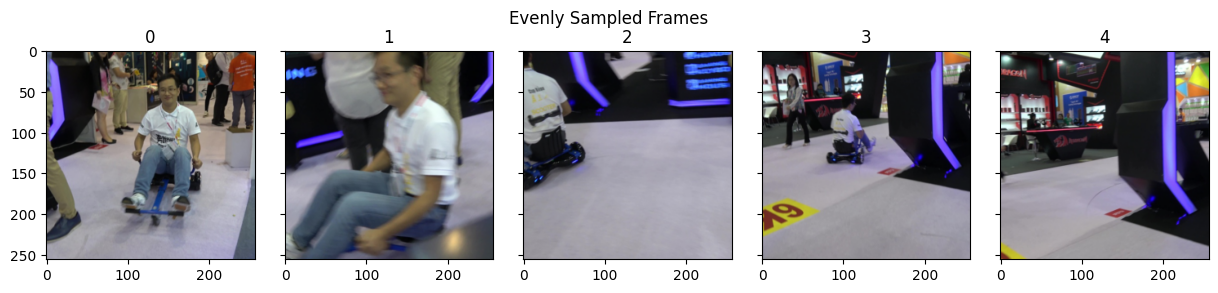

<ipython-input-6-589c496fbfb8>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


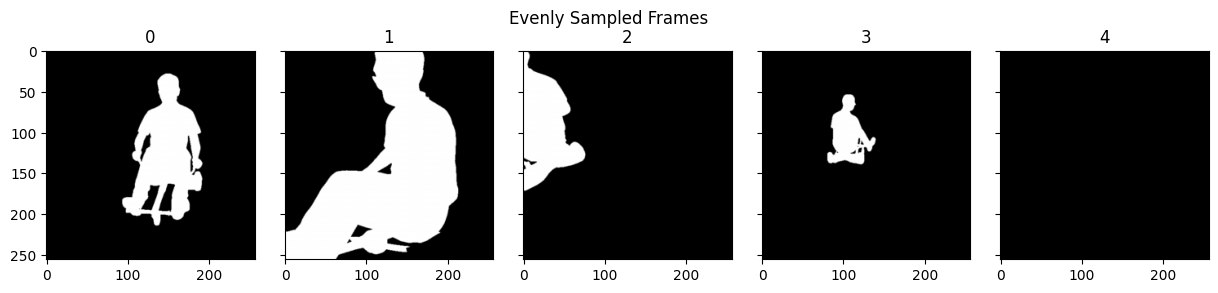

Dataset size :  60


In [7]:
video_dataset_demo()

## Download and unzip style dataset [Not required if already present on mounted google drive]

In [ ]:
!git clone https://github.com/himanshu1196/game-ai-style-transfer.git

Cloning into 'game-ai-style-transfer'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 107 (delta 8), reused 16 (delta 5), pack-reused 83
Receiving objects: 100% (107/107), 150.36 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
# !mv game-ai-style-transfer/data/style_random100.zip /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip
# !unzip /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip -d /content/drive/MyDrive/game_AI_project/data/style/all/
# !rm /content/drive/MyDrive/game_AI_project/data/style/all/random100.zip
# !mv /content/drive/MyDrive/game_AI_project/data/style/all/style_random100/* /content/drive/MyDrive/game_AI_project/data/style/all/
# !rm -rf /content/drive/MyDrive/game_AI_project/data/style/all/style_random100/

## Visualize style dataset

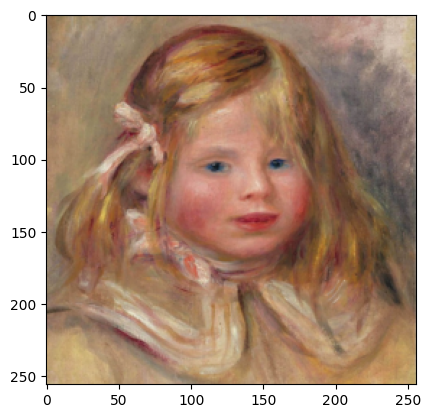

In [8]:
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

style_dataset = torchvision.datasets.ImageFolder(style_root, transforms.Compose([
    transforms.Resize(256),  # image batch, resize smaller edge to 299
    transforms.CenterCrop(256),  # image batch, center crop to square 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

rnd_idx = np.random.randint(100)
plt.imshow(denormalize(style_dataset[rnd_idx][0].unsqueeze(0))[0])

## Define MVST Dataset

In [9]:
import os
from PIL import Image
import torch.nn.functional as F

import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.io import read_video
from torch.utils.data import Dataset
import random
from video_dataset import  VideoFrameDataset, ImglistToTensor

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


class MVSTDataset(Dataset):
    def __init__(self,cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256):

        self.preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.preprocess_mask = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.cont_vids_path = cont_vids_path
        self.cont_mask_vids_path = cont_mask_vids_path
        self.annotation_file = annotations_path
        self.style_imgs_path = style_imgs_path
        self.style_img_files = self.list_files(style_imgs_path)
        self.img_size = img_size
        assert(num_classes == 2)
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size,self.img_size), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.FRAME_COUNT = 100
        self.dataset = VideoFrameDataset(
            root_path=cont_vids_path,
            annotationfile_path=annotations_path,
            num_segments=10,
            frames_per_segment=1,
            imagefile_template='{:05d}.jpg',
            transform=self.preprocess,
            test_mode=True
        )

        self.mask_dataset = VideoFrameDataset(
            root_path=cont_mask_vids_path,
            annotationfile_path=annotations_path,
            num_segments=10,
            frames_per_segment=1,
            imagefile_template='{:05d}.png',
            transform=self.preprocess_mask,
            test_mode=True
        )

        self.style_dataset = torchvision.datasets.ImageFolder(self.style_imgs_path, transforms.Compose([
            transforms.Resize(256),  # image batch, resize smaller edge to 299
            transforms.CenterCrop(256),  # image batch, center crop to square 299x299
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self,idx):
        # two random style images
        style_idx1 = np.random.randint(len(self.style_dataset))
        style_idx2 = np.random.randint(len(self.style_dataset))
        while style_idx2 == style_idx1:
            style_idx2 = np.random.randint(len(self.style_dataset))

        cont_idx = idx

        cont_vid_item = self.dataset.__getitem__(cont_idx)[0]
        cont_mask_vid_item = self.mask_dataset.__getitem__(cont_idx)[0]
        style_img_item1 = self.style_dataset.__getitem__(style_idx1)[0]
        style_img_item2 = self.style_dataset.__getitem__(style_idx2)[0]

        cont_mask_vid_item = torch.unsqueeze(cont_mask_vid_item, 0) # 1xFx3x256x256

        style_img_item1 = torch.unsqueeze(style_img_item1, 0) # 1x3x256x256
        style_img_item2 = torch.unsqueeze(style_img_item2, 0) # 1x3x256x256
        # print(f'loading : {cont_mask_vid_item.min()} {cont_mask_vid_item.max()} {(1-cont_mask_vid_item).min()} {(1-cont_mask_vid_item).max()}')
        return cont_vid_item, torch.cat([cont_mask_vid_item, 1-cont_mask_vid_item], dim=0), torch.cat([style_img_item1, style_img_item2], dim=0)


    def list_files(self, in_path):
        files = []
        for (dirpath, dirnames, filenames) in os.walk(in_path):
            files.extend(filenames)
            break
        files = sorted([os.path.join(in_path, x) for x in files])
        return files


In [10]:
!rm -rf /content/style/.ipynb_checkpoint*

### Visualize MVSTDataset

Using device: cpu


<ipython-input-9-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


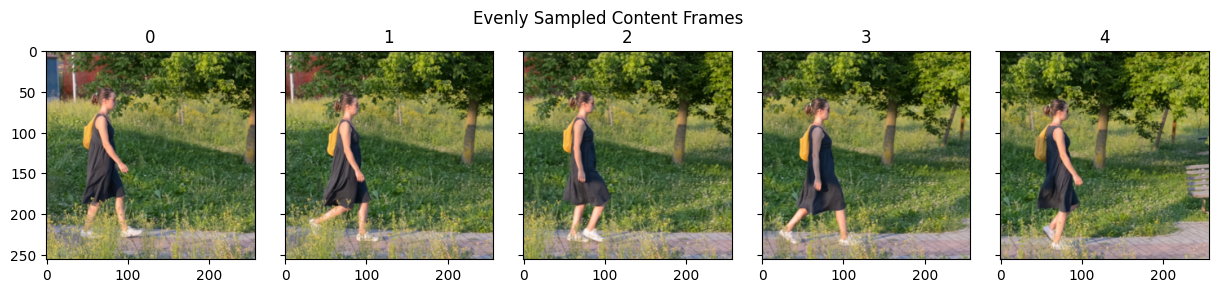

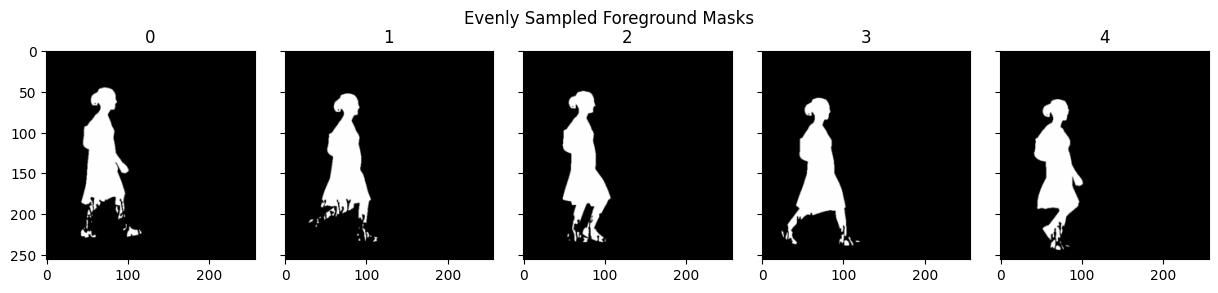

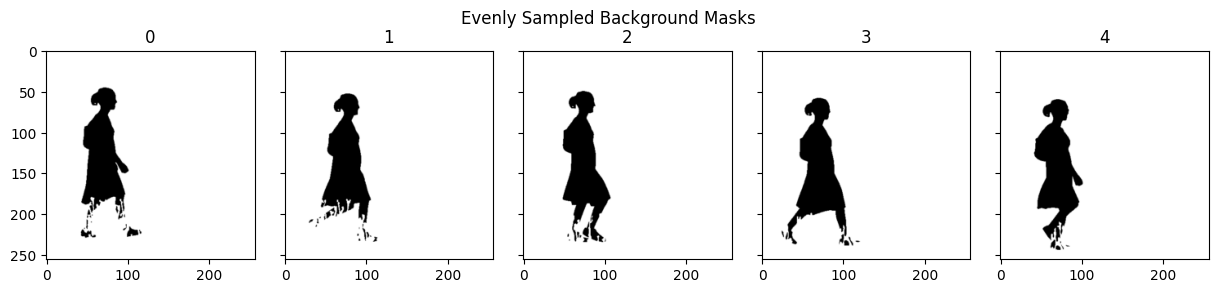

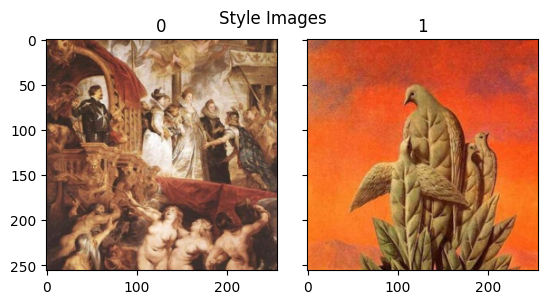

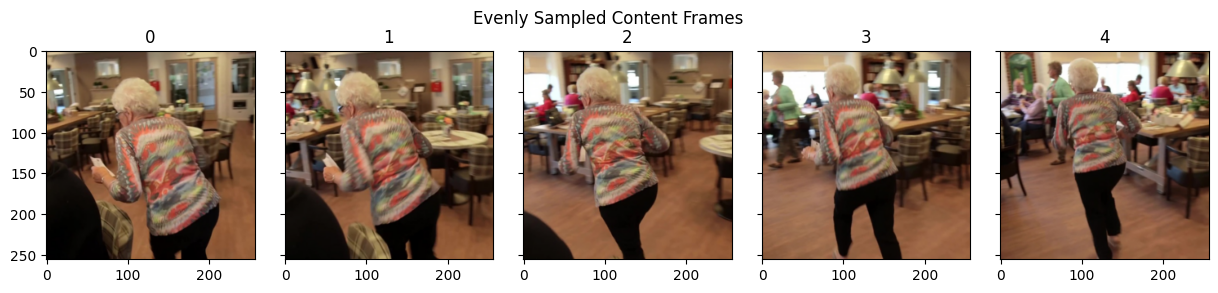

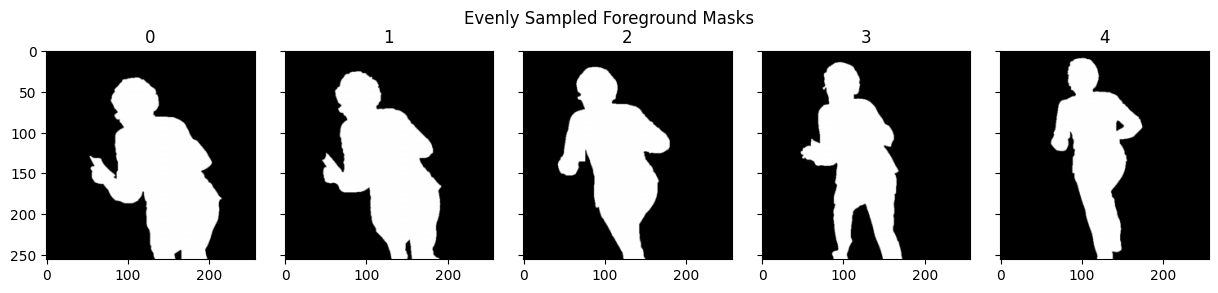

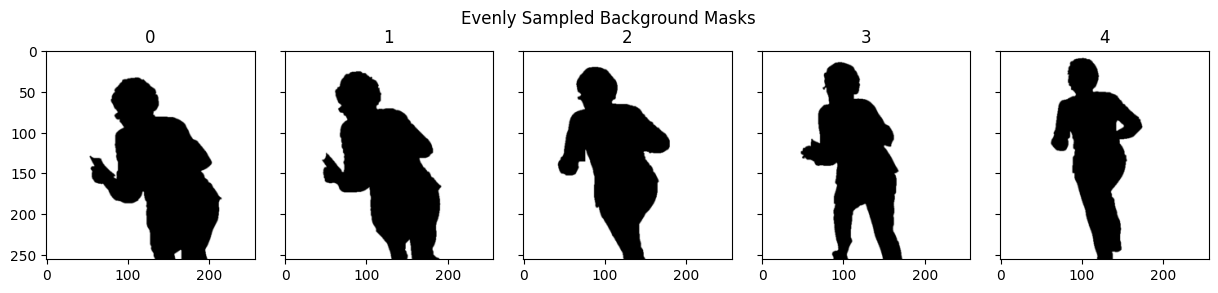

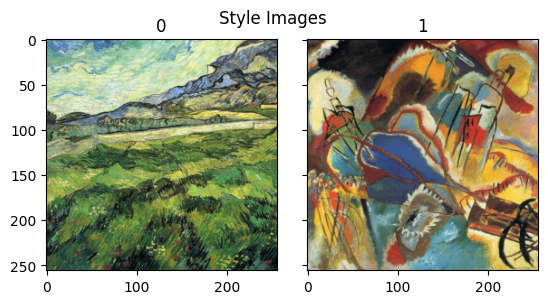

In [16]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
import sys

args = {}
args['cont_vids_path'] = vid_root #/vids
args['cont_mask_vids_path'] = mask_root #/mask_vids
args['annotations_path'] = annotations_file_train #/mask_vids
args['style_imgs_path'] = style_root #/style_images
args['num_classes'] = 2
args['batch_size'] = 2
args['checkpoint_path'] = checkpoints_root
args['output_path'] = sample_output_root
args['log_interval'] = 5
args['ckpt_interval'] = 10

cont_vids_path = args['cont_vids_path'] #/vids
cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
annotations_path = args['annotations_path'] #/annotations_path
style_imgs_path = args['style_imgs_path'] #/style_images
num_classes = args['num_classes'] #/num_classes
batch_size = args['batch_size']
checkpoint_path = args['checkpoint_path']
output_path = args['output_path']
log_interval = args['log_interval']
ckpt_interval = args['ckpt_interval']

# set dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
train_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path, style_imgs_path, num_classes, img_size=256)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

count = 0
for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(train_loader):
    #cont_img is B x num_frames x 3 x 256 x 256
    plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
               title='Evenly Sampled Content Frames')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Foreground Masks')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Background Masks')
    plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
               title='Style Images')
    count += 1
    if count >1:
        break

# Masked Video Style Transfer Model

### Define model

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torchvision import models
from torchsummary import summary
from torchvision.models.feature_extraction import create_feature_extractor

In [13]:
# model architecture

def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def st_ada_in(style_features, content_cur_masked_features, content_prev_masked_features, alpha = 0.1):
    # print('#', style_features.shape, content_cur_masked_features.shape, content_prev_masked_features.shape) #BxCxSxS

    x_cur_mean, x_cur_std = calc_mean_std(content_cur_masked_features)
    x_prev_mean, x_prev_std = calc_mean_std(content_prev_masked_features)

    # print('#', type(alpha), type(x_cur_mean), type(x_prev_mean))
    combined_mean = (1-alpha) * x_cur_mean + alpha * x_prev_mean
    combined_std = (1-alpha) * x_cur_std + alpha * x_prev_std

    style_mean, style_std = calc_mean_std(style_features)

    result = style_std * (content_cur_masked_features - combined_mean) / combined_std + style_mean
    # print('#', x_cur_mean.shape, style_mean.shape, result.shape)
    # print('STAdaIn :', x_cur_mean.squeeze()[:5], x_cur_std.squeeze()[:5], x_prev_mean.squeeze()[:5], x_prev_std.squeeze()[:5], style_mean.squeeze()[:5], style_std.squeeze()[:5], calc_mean_std(result)[0].squeeze()[:5], calc_mean_std(result)[1].squeeze()[:5])
    return result


def get_VGG_feature_extractor():
    # vgg_layer_names = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1"]
    # vgg_layer_names = ["ReLU-2", "ReLU-7", "ReLU-12", "ReLU-21"]
    vgg_fixed = torchvision.models.vgg19(weights='IMAGENET1K_V1')
    for param in vgg_fixed.parameters():
        param.requires_grad = False

    # train_nodes, eval_nodes = get_graph_node_names(vgg_fixed)
    # print(train_nodes, eval_nodes)

    # To specify the nodes you want to extract, you could select the final node
    # that appears in each of the main layers:
    return_nodes = {
        # node_name: user-specified key for output dict
        'features.2': 'layer1',
        'features.7': 'layer2',
        'features.12': 'layer3',
        'features.21': 'layer4',
    }

    return create_feature_extractor(vgg_fixed, return_nodes=return_nodes)


class SpatioTemporalTransferModel(nn.Module):
    def __init__(self, vgg_feature_extractor):
        super(SpatioTemporalTransferModel, self).__init__()
        self.vgg_feature_extractor = vgg_feature_extractor

        #define splatting blocks' layers
        self.sb_11 = ConvBlock(in_channels=64, out_channels=8, kernel_size=3,  padding="same", stride=2)
        self.sb_12 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_13 = ConvBlock(in_channels=8, out_channels=8, kernel_size=3,  padding="same", stride=1)
        self.sb_1_short = nn.Conv2d(in_channels=128, out_channels=8, kernel_size=1, stride=1)

        self.sb_21 = ConvBlock(in_channels=8, out_channels=16, kernel_size=3,  padding="same", stride=2)
        self.sb_22 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_23 = ConvBlock(in_channels=16, out_channels=16, kernel_size=3,  padding="same", stride=1)
        self.sb_2_short = nn.Conv2d(in_channels=256, out_channels=16, kernel_size=1,  stride=1)

        self.sb_31 = ConvBlock(in_channels=16, out_channels=32, kernel_size=3,  padding="same", stride=2)
        self.sb_32 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_33 = ConvBlock(in_channels=32, out_channels=32, kernel_size=3,  padding="same", stride=1)
        self.sb_3_short = nn.Conv2d(in_channels=512, out_channels=32, kernel_size=1, stride=1)

        self.l_1 = ConvBlock(in_channels=32, out_channels=64, kernel_size=3,  padding="same", stride=2)
        self.l_2 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3,  padding="same", stride=1)

        self.gp_1 = ConvBlock(in_channels=64, out_channels=64, kernel_size=3,  padding="same", stride=1)

        self.gp_2 = ConvBlock(in_channels=64, out_channels=96, kernel_size=1,  padding="same", stride=1, activation=None) #TODO : activation none?
        return

    def forward(self, style, content, mask, mask_prev, cpe_1, cpe_2, cpe_3, cpe_4, adap_1, adap_2, adap_3):
        # Encode the style and content image.

        style_encoded_dict = self.vgg_feature_extractor(style)
        style_encoded = [style_encoded_dict[f'layer{i}'] for i in range(1,5)]

        content_encoded_dict = self.vgg_feature_extractor(content * mask)
        content_encoded = [content_encoded_dict[f'layer{i}'] for i in range(1,5)]

        # Compute the AdaIN target feature maps.
        st_ada_in_outputs = []
        # skip block1_conv1
        skipCount = 1
        count = 0
        content_prev_encoded = [cpe_1, cpe_2, cpe_3, cpe_4]
        for encoded_features in zip(style_encoded, content_encoded, content_prev_encoded):
            # print('! ', count)
            if count < skipCount:
                count += 1
                continue
            # TODO : consider mask shape
            st_ada_in_output = st_ada_in(encoded_features[0], encoded_features[1], encoded_features[2], alpha = 0.1)
            st_ada_in_outputs.append(st_ada_in_output)

        temp_content = self.sb_11(content_encoded[0]) #input is c_in
        temp_style = self.sb_11(style_encoded[0]) #input is s_in
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_1, alpha = 0.1)
        adap_1 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_1_short(st_ada_in_outputs[0])
        temp_content_stylized = self.sb_12(temp_content_stylized)
        temp_content_stylized = self.sb_13(temp_content_stylized) #c_out
        # print('here', temp_style.shape)
        temp_style = self.sb_13(temp_style) #s_out
        # print('STM sb1: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content = self.sb_21(temp_content_stylized) #input is c_in
        # print('STM sb21: ', temp_content.shape, temp_content.min(), temp_content.max())
        temp_style = self.sb_21(temp_style) #input is s_in
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_2, alpha = 0.1)
        # print('STM sb2ada: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        adap_2 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_2_short(st_ada_in_outputs[1])
        # print('STM sb2sum: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.sb_22(temp_content_stylized)
        # print('STM sb22: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.sb_23(temp_content_stylized) #c_out
        # print('STM sb23: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_style = self.sb_23(temp_style) #s_out
        # print('STM sb2: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content = self.sb_31(temp_content_stylized) #input is c_in
        temp_style = self.sb_31(temp_style) #input is s_in
        temp_content_stylized = st_ada_in(temp_style, temp_content, adap_3, alpha = 0.1)
        adap_3 = temp_content.clone().detach()
        temp_content_stylized = temp_content_stylized + self.sb_3_short(st_ada_in_outputs[2])
        temp_content_stylized = self.sb_32(temp_content_stylized)
        temp_content_stylized = self.sb_33(temp_content_stylized) #c_out
        temp_style = self.sb_33(temp_style) #s_out
        # print('STM sb3: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.l_1(temp_content_stylized)
        # print('STM l1: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        temp_content_stylized = self.l_2(temp_content_stylized) #stylized_features
        # print('STM l2: ', temp_content_stylized.shape, temp_content_stylized.min(), temp_content_stylized.max())
        #grid prediction
        bilateral_grid = self.gp_1(temp_content_stylized)
        bilateral_grid = self.gp_2(bilateral_grid)

        content_prev_encoded = content_encoded.copy()
        # print('STM bg: ', bilateral_grid.shape, bilateral_grid.min(), bilateral_grid.max())
        # plt.matshow(torch.sum(temp_content_stylized.squeeze(), dim= (0)).cpu().detach().numpy())
        # plt.show()

        return bilateral_grid, content_prev_encoded[0], content_prev_encoded[1], content_prev_encoded[2], content_prev_encoded[3], adap_1, adap_2, adap_3,


class SoftGridMask(nn.Module):
    def __init__(self):
        super(SoftGridMask, self).__init__()

    def create_soft_grid_mask(self, z, M_px, w, h, W, H, D):
        device = z.get_device()

        #TODO check algo
        B = M_px.shape[0] #batch size
        M_grid = torch.zeros((B, D, W, H), dtype=torch.float32)
        if device >= 0:
            M_grid = M_grid.to(device)
        # print((z * M_px * D).shape)
        z_D = torch.floor((z * M_px) * D) # B x 1 x h x w
        s_w, s_h = w//W, h//H

        for x in range(W):
            for y in range(H):
                patch = z_D[:, 0, x * s_w : (x + 1) * s_w, y*s_h:(y+1)*s_h] # B x s_w x s_h
                temp = torch.sum(torch.where(patch > 0, torch.ones_like(patch), torch.zeros_like(patch)), dim = (1, 2)) # B scalars
                # print("patch.shape ",z_D.shape, patch.shape, temp.shape, z_D.min(), z_D.max(), torch.any(patch > 0), temp)
                M_grid[:,:,x,y] = temp.unsqueeze(1).repeat(1,D) #B x D
                for d in range(D):
                    d_in_patch = torch.any(patch == d, dim = (1,2)) #B scalars
                    for b in range(B):
                        if d_in_patch[b]:
                            temp = torch.sum(torch.where(patch[b,:,:] == d, torch.ones_like(patch[b,:,:]), torch.zeros_like(patch[b,:,:]))) #scalar
                            # print('____', temp)
                            M_grid[b,d,x,y] = temp
        M_grid = M_grid / (s_w * s_h)
        return M_grid

    def forward(self, z, M_px, w, h, W, H, D):
        #use only one channel of the mask
        B = M_px.shape[0]
        sgm = self.create_soft_grid_mask(z, M_px[:, 0:1, :, :], w, h, W, H, D)
        # print('SGM : min, max', z.min(), z.max(), M_px.min(), M_px.max(), sgm.min(), sgm.max())
        # plt.matshow(z[0,0].cpu().detach().numpy())
        # plt.matshow( M_px[0, 0, :, :].cpu().detach().numpy())
        # plt.matshow(torch.sum(sgm, dim = 1)[0].cpu().detach().numpy())
        # plt.show()
        return sgm


class GridBlender(nn.Module):
    def __init__(self):
        super(GridBlender, self).__init__()

    def forward(self, grids, soft_grid_masks):
        #TODO : use grid blending function
        # print(len(grids), grids[0].shape, soft_grid_mask.shape)
        a = torch.multiply(soft_grid_masks[0], grids[0])
        b = torch.multiply(soft_grid_masks[1], grids[1])
        out = torch.add(a,b) #B x D x H x W
        # print('GB : ', a.shape, b.shape, out.shape, a.min(), a.max(), b.min(), b.max(), out.min(), out.max())
        # plt.matshow(torch.sum(out, dim = 1)[0].cpu().detach().numpy())
        # plt.show()
        return out

#########################################################################################################
class MaskedVideoStyleTransfer(nn.Module):
    def __init__(self, slice, apply):
        super(MaskedVideoStyleTransfer, self).__init__()
        self.vgg_feature_extractor = get_VGG_feature_extractor()
        self.spatio_temporal_model = SpatioTemporalTransferModel(self.vgg_feature_extractor)
        self.grid_blender = GridBlender()
        self.guide = GuideNN()
        self.slice = slice
        self.apply_coeffs = apply
        self.soft_grid_mask = SoftGridMask()



    def forward(self, content, mask_cur_list, style_list, mask_prev_list, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all):
        # model : torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 3, 256, 256]) torch.Size([2, 2, 3, 256, 256]) torch.Size([2, 2, 64, 224, 224]) torch.Size([2, 2, 128, 112, 112]) torch.Size([2, 2, 256, 56, 56]) torch.Size([2, 2, 512, 28, 28]) torch.Size([2, 2, 8, 112, 112]) torch.Size([2, 2, 16, 56, 56]) torch.Size([2, 2, 32, 28, 28])
        # print('model :', content.shape, mask_cur_list.shape, style_list.shape, mask_prev_list.shape, cpe_1_all.shape, cpe_2_all.shape, cpe_3_all.shape, cpe_4_all.shape, adap_1_all.shape, adap_2_all.shape, adap_3_all.shape)

        bilateral_grid_list = []
        for classId in range(mask_cur_list.shape[1]):
            bilateral_grid, cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3 = self.spatio_temporal_model(style_list[:,classId,:,:,:], content, mask_cur_list[:,classId,:,:,:], mask_prev_list[:,classId,:,:,:], cpe_1_all[:,classId,:,:,:], cpe_2_all[:,classId,:,:,:], cpe_3_all[:,classId,:,:,:], cpe_4_all[:,classId,:,:,:], adap_1_all[:, classId, :, :, :], adap_2_all[:, classId, :, :, :], adap_3_all[:, classId, :, :, :])

            cpe_1_all[:,classId, :, :, :], cpe_2_all[:,classId, :, :, :], cpe_3_all[:,classId, :, :, :], cpe_4_all[:,classId, :, :, :], adap_1_all[:, classId, :, :, :], adap_2_all[:, classId, :, :, :], adap_3_all[:, classId, :, :, :] = cpe_1_, cpe_2_, cpe_3_, cpe_4_, adap_1, adap_2, adap_3

            bilateral_grid_list.append(bilateral_grid)

        guide = self.guide(content)
        # TODO : replace after fixing mask loss
        # guide = torchvision.transforms.Grayscale(num_output_channels=1)(content)
        soft_grid_mask_foreground = self.soft_grid_mask(guide, mask_cur_list[:,0,:,:,:], 256, 256, 16, 16, 96) #assuming 2 classes in the order foreground, background, first dimension is batch
        # soft_grid_mask_background = self.soft_grid_mask(guide, mask_cur_list[:,1,:,:,:], 256, 256, 16, 16, 96) #paper uses complement of sgmf instead of calculating it using background mask
        soft_grid_mask_background = torch.ones_like(soft_grid_mask_foreground).to(soft_grid_mask_foreground.device) - soft_grid_mask_foreground #assuming 2 classes in the order foreground, background, first dimension is batch
        #TODO: handle multiple masks, one for each class
        blended_grid = self.grid_blender(bilateral_grid_list, [soft_grid_mask_foreground, soft_grid_mask_background])
        blended_grid_ = blended_grid.reshape(blended_grid.shape[0],12,-1,blended_grid.shape[-2],blended_grid.shape[-1])
        slice_coeffs = self.slice(blended_grid_, guide)
        output = self.apply_coeffs(slice_coeffs, content)

        return output, blended_grid, bilateral_grid_list, soft_grid_mask_foreground, soft_grid_mask_background, bilateral_grid_list, guide, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all
########################################################################################################

class LaplacianRegularizer3D(nn.Module):
    def __init__(self):
        super(LaplacianRegularizer3D, self).__init__()
        self.mse_loss = torch.nn.MSELoss(reduction='sum')

    def forward(self, f):
        loss = 0.
        # f: [B, 12, 8, H, W]
        f = f.reshape(f.shape[0],12,8,f.shape[2],f.shape[-1])
        B, C, D, H, W = f.shape
        for k in range(D):
            for i in range(H):
                for j in range(W):
                    front = max(k - 1, 0)
                    back = min(k + 1, D - 1)
                    up = max(i - 1, 0)
                    down = min(i + 1, H - 1)
                    left = max(j - 1, 0)
                    right = min(j + 1, W - 1)
                    term = f[:, :, k, i, j].view(B, C, 1, 1, 1).expand(B, C, back - front + 1, down - up + 1, right - left + 1)
                    loss += self.mse_loss(term, f[:, :, front:back + 1, up:down + 1, left:right + 1])
        return loss


class Slice(nn.Module):
    def __init__(self):
        super(Slice, self).__init__()

    def forward(self, bilateral_grid, guidemap):
        device = bilateral_grid.get_device()

        N, _, H, W = guidemap.shape
        hg, wg = torch.meshgrid([torch.arange(0, H), torch.arange(0, W)]) # [0,255] HxW
        if device >= 0:
            hg = hg.to(device)
            wg = wg.to(device)
        hg = hg.float().repeat(N, 1, 1).unsqueeze(3) / (H-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        wg = wg.float().repeat(N, 1, 1).unsqueeze(3) / (W-1) * 2 - 1 # norm to [-1,1] NxHxWx1
        guidemap = (guidemap * 2 - 1.0).permute(0,2,3,1).contiguous()
        guidemap_guide = torch.cat([wg, hg, guidemap], dim=3).unsqueeze(1) # Nx1xHxWx3
        coeff = F.grid_sample(bilateral_grid, guidemap_guide, align_corners=True)
        # print('Slice__: ', wg.shape, wg.min(), wg.max(), hg.shape, hg.min(), hg.max(), guidemap.shape, guidemap.min(), guidemap.max())
        # print('Slice: ', bilateral_grid.shape, bilateral_grid.min(), bilateral_grid.max(), guidemap_guide.shape, guidemap_guide.min(), guidemap_guide.max(), coeff.shape, coeff.min(), coeff.max())
        return coeff.squeeze(2)


class ApplyCoeffs(nn.Module):
    def __init__(self):
        super(ApplyCoeffs, self).__init__()
        self.degree = 3

    def forward(self, coeff, full_res_input):

        '''
            Affine:
            r = a11*r + a12*g + a13*b + a14
            g = a21*r + a22*g + a23*b + a24
            ...
        '''

        R = torch.sum(full_res_input * coeff[:, 0:3, :, :], dim=1, keepdim=True) + coeff[:, 3:4, :, :]
        G = torch.sum(full_res_input * coeff[:, 4:7, :, :], dim=1, keepdim=True) + coeff[:, 7:8, :, :]
        B = torch.sum(full_res_input * coeff[:, 8:11, :, :], dim=1, keepdim=True) + coeff[:, 11:12, :, :]

        out = torch.cat([R, G, B], dim=1)
        # print('Apply : ', coeff.shape, coeff.min(), coeff.max(), full_res_input.shape, full_res_input.min(), full_res_input.max(), out.shape, out.min(), out.max())
        return out


class GuideNN(nn.Module):
    def __init__(self, params=None):
        super(GuideNN, self).__init__()
        self.params = params
        self.conv1 = ConvBlock(3, 16, kernel_size=1, padding=0, batch_norm=False)
        self.conv2 = ConvBlock(16, 1, kernel_size=1, padding=0, activation=nn.Sigmoid)

    def forward(self, x):
        return self.conv2(self.conv1(x))


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding="same", stride=1, use_bias=True, activation=nn.ReLU,
                 batch_norm=False):
        super(ConvBlock, self).__init__()
        reflection_padding = kernel_size // 2 # same dimension after padding
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), kernel_size, stride=stride, bias=use_bias)
        self.activation = activation() if activation else None
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        if self.activation:
            x = self.activation(x)
        return x


## Util functions and loss functions

In [14]:
def warp_with_flow(x, flo):
    """
    x: [B, C, H, W] (prev_image)
    flo: [B, 2, H, W] flow

    """
    device = x.get_device()
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
    yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
    xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    grid = torch.cat((xx ,yy), 1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
    vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    flo = flo.permute(0, 2, 3, 1)
    output = F.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size()))
    if device >= 0:
        mask = mask.to(device)
    mask = F.grid_sample(mask, vgrid)

    mask[mask <0.9999] = 0
    mask[mask >0] = 1

    return output*mask

In [15]:

mse_loss = nn.MSELoss()
# mse_loss_sum = nn.MSELoss(reduction = 'sum')

def calc_content_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def calc_style_loss(input, target):
    #inputs are extracted layer features of images
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    input_mean, input_std = calc_mean_std(input)
    target_mean, target_std = calc_mean_std(target)
    # print('s loss ', input_mean.shape, target_mean.shape, input_std.shape, target_std.shape)
    return mse_loss(input_mean, target_mean) + \
            mse_loss(input_std, target_std)

def content_and_style_loss( content_feat, out_content_feat,  style_feats, out_style_feats, alpha=1.0):
    assert 0 <= alpha <= 1
    # print('c loss ', out_content_feat.shape, content_feat.shape)
    loss_c = calc_content_loss(out_content_feat, content_feat)
    loss_s = calc_style_loss(out_style_feats[0], style_feats[0])
    for i in range(1, 4):
        loss_s += calc_style_loss(out_style_feats[i], style_feats[i])
    return loss_c, loss_s

def lumin_loss(guide, content_grayscale):
    assert (guide.size() == content_grayscale.size())
    assert (content_grayscale.requires_grad is False)
    return mse_loss(guide, content_grayscale)

def mask_loss(input, target):
    assert (input.size() == target.size())
    assert (target.requires_grad is False)
    return mse_loss(input, target)

def temporal_loss(flo, output_cur, output_prev):
    assert (output_cur.size() == output_prev.size())
    assert (output_prev.requires_grad is False)
    warped_output = warp_with_flow(output_prev, flo)
    return mse_loss(output_cur, warped_output)

## Check individual components of the model

In [ ]:
stm = SpatioTemporalTransferModel(get_VGG_feature_extractor().to(device)).to(device)
V = 256
D = 224
temp = np.ones((1,3,V,V))
temp_style = np.ones((1,3,V,V))
temp_mask = np.ones((1,3,V,V))
# print(temp.shape)

a,b1, b2, b3, b4,c,d,e = stm.forward(torch.tensor(temp_style, dtype=torch.float32).to(device), torch.tensor(temp, dtype=torch.float32).to(device),
            torch.tensor(temp_mask, dtype=torch.float32).to(device), torch.tensor(temp_mask, dtype=torch.float32).to(device), torch.zeros((1, 64, 256, 256), dtype=torch.float32).to(device),
            torch.zeros((1, 128, 112, 112), dtype=torch.float32).to(device), torch.zeros((1, 256, 64, 64), dtype=torch.float32).to(device),
            torch.zeros((1, 512, 32, 32), dtype=torch.float32).to(device),
            torch.zeros((1, 8, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 16, 64, 64), dtype=torch.float32).to(device),
            torch.zeros((1,  32, 32, 32), dtype=torch.float32).to(device))
print(a.shape, b1.shape, b2.shape, b3.shape, b4.shape, c.shape, d.shape, e.shape)

torch.Size([1, 96, 16, 16]) torch.Size([1, 64, 256, 256]) torch.Size([1, 128, 128, 128]) torch.Size([1, 256, 64, 64]) torch.Size([1, 512, 32, 32]) torch.Size([1, 8, 128, 128]) torch.Size([1, 16, 64, 64]) torch.Size([1, 32, 32, 32])


In [ ]:
g = GuideNN().to(device)
z = g(torch.zeros((1, 3, 256, 256), dtype=torch.float32).to(device))
print(z.shape)

torch.Size([1, 1, 256, 256])


In [ ]:
sgm = SoftGridMask().to(device)
sm = sgm(z, torch.zeros((2, 3, 256, 256), dtype=torch.float32).to(device), 256, 256, 16, 16, 96)
print(sm.shape)

torch.Size([2, 96, 16, 16])


In [ ]:
slice = Slice().to(device)
slice_coeffs = slice(a.reshape(a.shape[0],12,-1,a.shape[-2],a.shape[-1]), z)
print(slice_coeffs.shape)

torch.Size([1, 12, 256, 256])


In [ ]:
apply = ApplyCoeffs().to(device)
apply_coeffs = apply(slice_coeffs, torch.tensor(temp, dtype=torch.float32).to(device))
print(apply_coeffs.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
gb = GridBlender().to(device)
bg = gb([torch.zeros((1, 12, 8, 16, 16), dtype=torch.float32).to(device), torch.ones((1, 12, 8, 16, 16), dtype=torch.float32).to(device)], [torch.zeros((1, 12, 8, 16, 16), dtype=torch.float32).to(device), torch.ones((1, 12, 8, 16, 16), dtype=torch.float32).to(device)])
print(bg.shape)

torch.Size([1, 12, 8, 16, 16])


In [ ]:
mvs = MaskedVideoStyleTransfer(slice, apply).to(device)
out = mvs.forward(torch.zeros((1, 3, 256, 256), dtype=torch.float32).to(device), torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 3, 256, 256), dtype=torch.float32).to(device), torch.zeros((1, 2, 64, 256, 256), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 128, 128, 128), dtype=torch.float32).to(device), torch.zeros((1, 2, 256, 64, 64), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 512, 32, 32), dtype=torch.float32).to(device), torch.zeros((1, 2, 8, 128, 128), dtype=torch.float32).to(device),
                  torch.zeros((1, 2, 16, 64, 64), dtype=torch.float32).to(device), torch.zeros((1, 2, 32, 32, 32), dtype=torch.float32).to(device))
print(out[0].shape)

torch.Size([1, 3, 256, 256])


# Train and validate model

## Train and save model

In [25]:
from torch.utils.data import DataLoader
from torch.optim import SGD, Adam
from torchvision.models.optical_flow import raft_small
from torchvision.models.optical_flow import Raft_Small_Weights
from torchvision.utils import save_image,make_grid
import sys

def sample_image(model, batch, epoch, output_path):
    cont_img,mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = batch
    batch_size = cont_img.shape[0]

    model.eval()

    output, blended_grid, bilateral_grid_list, soft_grid_mask_f, soft_grid_mask_b, bilateral_grid_list, guide, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img,mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

    out = make_grid(output, nrow=batch_size, normalize=True)
    save_image(out, os.path.join(output_path, 'output_with_mask'+str(epoch)+'.jpg'), normalize=False)
    cont = make_grid(cont_img, nrow=batch_size, normalize=True)
    save_image(cont, os.path.join(output_path, 'cont'+str(epoch)+'.jpg'), normalize=False)
    mask = make_grid(mask_img_list, nrow=batch_size, normalize=True)
    save_image(mask, os.path.join(output_path, 'mask'+str(epoch)+'.jpg'), normalize=False)
    style = make_grid(style_img_list, nrow=batch_size, normalize=True)
    save_image(style, os.path.join(output_path, 'style'+str(epoch)+'.jpg'), normalize=False)

    model.train()
    return

def plot_all_losses(all_losses, output_path, epoch, is_validation=False):
    c_loss_hist, s_loss_hist, r_loss_hist, z_loss_hist, m_loss_hist, t_loss_hist, loss_hist = all_losses
    plt.plot(range(len(loss_hist)), c_loss_hist, label='C')
    plt.plot(range(len(loss_hist)), s_loss_hist, label='S')
    plt.plot(range(len(loss_hist)), r_loss_hist, label='R')
    plt.plot(range(len(loss_hist)), z_loss_hist, label='Z')
    plt.plot(range(len(loss_hist)), m_loss_hist, label='M')
    plt.plot(range(len(loss_hist)), t_loss_hist, label='T')
    plt.plot(range(len(loss_hist)), loss_hist, label='total')
    plt.legend()
    if is_validation:
        plt.savefig(os.path.join(output_path, 'val_losses_with_mask_e'+str(epoch)+'.jpg'))
    else:
        plt.savefig(os.path.join(output_path, 'losses_with_mask_e'+str(epoch)+'.jpg'))
    return



args = {}
args['cont_vids_path'] = vid_root #/vids
args['cont_mask_vids_path'] = mask_root #/mask_vids
args['annotations_path_train'] = annotations_file_train #/mask_vids
args['annotations_path_val'] = annotations_file_val #/mask_vids
args['style_imgs_path'] = style_root #/style_images
args['num_classes'] = 2
args['batch_size'] = 2
args['checkpoint_path'] = checkpoints_root
args['output_path'] = sample_output_root
args['log_interval'] = 1
args['ckpt_interval'] = 1

In [ ]:
def train(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path_train = args['annotations_path_train'] #/annotations_path_train
    annotations_path_val = args['annotations_path_val'] #/annotations_path_val
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes
    batch_size = args['batch_size']
    checkpoint_path = args['checkpoint_path']
    output_path = args['output_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    train_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_train, style_imgs_path, num_classes, img_size=256)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()

    vgg_feature_extractor = get_VGG_feature_extractor().to(device)
    slice = Slice().to(device)
    apply = ApplyCoeffs().to(device)
    model = MaskedVideoStyleTransfer(slice, apply).to(device)
    if os.path.exists(checkpoints_root + '/ckpt_with_mask_0_49.pth.pth'):
        checkpoint = torch.load(checkpoints_root + '/ckpt_with_mask_0_49.pth')
        model.load_state_dict(checkpoint)
    optimizer = Adam(model.parameters(), lr=1e-4)
    L_loss = LaplacianRegularizer3D().to(device)
    epochs = 1
    batch_done = 0

    # track losses
    lam_c = 0.1
    lam_s = 1
    lam_r = 0.02
    lam_z = 10
    lam_m = 5
    lam_t = 1000
    c_loss_hist = []
    s_loss_hist = []
    r_loss_hist = []
    z_loss_hist = []
    m_loss_hist = []
    t_loss_hist = []
    loss_hist = []

    # training iteration
    for e in range(epochs):
        model.train()
        for batch_idx ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(train_loader):
            #cont_img is B x num_frames x 3 x 256 x 256
            # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
            bs = cont_imgs.shape[0]
            cpe_1_all = torch.randn(size=(bs, num_classes, 64, 256, 256), dtype=torch.float32).to(device)
            cpe_2_all = torch.randn(size=(bs, num_classes, 128, 128, 128), dtype=torch.float32).to(device)
            cpe_3_all = torch.randn(size=(bs, num_classes, 256, 64, 64), dtype=torch.float32).to(device)
            cpe_4_all = torch.randn(size=(bs, num_classes, 512, 32, 32), dtype=torch.float32).to(device)
            adap_1_all = torch.randn(size=(bs, num_classes, 8, 128, 128), dtype=torch.float32).to(device)
            adap_2_all = torch.randn(size=(bs, num_classes, 16, 64, 64), dtype=torch.float32).to(device)
            adap_3_all = torch.randn(size=(bs, num_classes, 32, 32, 32), dtype=torch.float32).to(device)
            output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
            mask_img_list_prev = torch.randn(size=(bs, num_classes, 3, 256, 256), dtype=torch.float32).to(device)

            for frame_idx in range(cont_imgs.shape[1]):
                optimizer.zero_grad()
                cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
                mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
                style_img_list = style_img_lists.to(device)
                # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

                all_cont_feats = vgg_feature_extractor(cont_img)
                cont_feat = all_cont_feats['layer4']
                all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
                style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]
                # print('cpe1', cpe_1_all[:,:,0,0,0])
                output, blended_grid, bilateral_grid_list, soft_grid_mask_f, soft_grid_mask_b, bilateral_grid_list, guide, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

                all_out_feats = vgg_feature_extractor(output)
                # TODO should take mask into account wrt output?
                output_f = output * mask_img_list[:, 0, :, :, :]
                output_b = output * mask_img_list[:, 1, :, :, :]
                all_out_f_feats = vgg_feature_extractor(output_f)
                all_out_b_feats = vgg_feature_extractor(output_b)
                both_out_feats = [all_out_f_feats, all_out_b_feats]

                ####
                loss_c_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                loss_s_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                for i in range(num_classes):
                    loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[i][f'layer{j+1}'] for j in range(4)], [both_out_feats[i][f'layer{j+1}'] for j in range(4)])
                    loss_c_agg += loss_c
                    loss_s_agg += loss_s

                loss_r = L_loss(bilateral_grid_list[0]) + L_loss(bilateral_grid_list[1])
                loss_z = lumin_loss(torchvision.transforms.Normalize((0.5,), (0.5))(guide) , torchvision.transforms.Grayscale(num_output_channels=1)(cont_img))
                #TODO : update mask loss
                soft_grid_mask_f_ = soft_grid_mask_f.reshape(soft_grid_mask_f.shape[0],12,-1,soft_grid_mask_f.shape[-2],soft_grid_mask_f.shape[-1])
                # soft_grid_mask_b_ = soft_grid_mask_b.reshape(soft_grid_mask_b.shape[0],12,-1,soft_grid_mask_b.shape[-2],soft_grid_mask_b.shape[-1])
                reconstructed_mask_f = apply(slice(soft_grid_mask_f_, guide), guide)
                # reconstructed_mask_b = apply(slice(soft_grid_mask_b_, guide), guide)
                # loss_m = torch.tensor(0.0, dtype=torch.float32).to(device)
                # print(soft_grid_mask_.shape, guide.shape, mask_img_list.shape, reconstructed_mask.shape)
                # only wrt foreground mask?
                loss_m = mask_loss(reconstructed_mask_f, mask_img_list[:, 0, :, :, :]) # + mask_loss(reconstructed_mask_b, mask_img_list[:, 1, :, :, :])
                list_of_flows = flow_model(output, output_prev) #last one in the list is the most accurate

                loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

                total_loss = lam_c * loss_c_agg + lam_s * loss_s_agg + lam_r * loss_r + lam_z * loss_z + lam_m * loss_m + lam_t * loss_t

                c_loss_hist.append(loss_c_agg.item())
                s_loss_hist.append(loss_s_agg.item())
                r_loss_hist.append(loss_r.item())
                z_loss_hist.append(loss_z.item())
                m_loss_hist.append(loss_m.item())
                t_loss_hist.append(loss_t.item())
                loss_hist.append(total_loss.item())

                #backprop loss
                total_loss.backward()
                #update params
                optimizer.step()

                output_prev = output.clone().detach()
                mask_img_list_prev = mask_img_list.clone().detach()

                # Print log
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Frame %d/%d] [C loss: %f, S loss: %f, R loss: %f, Z loss: %f, M loss: %f, T loss: %f, total loss: %f]"
                    % (
                        e,
                        epochs,
                        batch_idx,
                        len(train_loader),
                        frame_idx,
                        cont_imgs.shape[1],
                        loss_c_agg.item(),
                        loss_s_agg.item(),
                        loss_r.item(),
                        loss_z.item(),
                        loss_m.item(),
                        loss_t.item(),
                        total_loss.item(),
                    )
                )
            if (batch_done+1) % log_interval == 0:
                # cont_imgs, mask_img_lists, style_img_lists:
                #cont_img is B x num_frames x 3 x 256 x 256
                plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
                        title='Evenly Sampled Content Frames')
                plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
                        title='Evenly Sampled Foreground Masks')
                plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
                        title='Evenly Sampled Background Masks')
                plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
                        title='Random Style Images')
                batch = [cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all]
                all_losses = [lam_c * np.array(c_loss_hist), lam_s * np.array(s_loss_hist), lam_r * np.array(r_loss_hist), lam_z * np.array(z_loss_hist), lam_m * np.array(m_loss_hist), lam_t * np.array(t_loss_hist), np.array(loss_hist)]
                sample_image(model, batch, e, output_path)
                plot_all_losses(all_losses, output_path, e, False)

            if (batch_done + 1) % ckpt_interval == 0:
                model.eval().cpu()
                ckpt_model_filename = "ckpt_with_mask_" + str(e) + '_' + str(batch_done) + ".pth"
                ckpt_model_path = os.path.join(checkpoint_path, ckpt_model_filename)
                torch.save(model.state_dict(), ckpt_model_path)
                model.to(device).train()
            batch_done += 1
    return

Using device: cpu


<ipython-input-8-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Epoch 0/1] [Batch 0/60] [Frame 0/10] [C loss: 142.327835, S loss: 211.486923, R loss: 10659.548828, Z loss: 1.365256, M loss: 0.128856, T loss: 0.116168, total loss: 569.375610]
[Epoch 0/1] [Batch 0/60] [Frame 1/10] [C loss: 122.374832, S loss: 223.257004, R loss: 9558.798828, Z loss: 1.289072, M loss: 0.121815, T loss: 0.001870, total loss: 442.040039]
[Epoch 0/1] [Batch 0/60] [Frame 2/10] [C loss: 126.668213, S loss: 203.113754, R loss: 8884.267578, Z loss: 1.417462, M loss: 0.197622, T loss: 0.002021, total loss: 410.649506]
[Epoch 0/1] [Batch 0/60] [Frame 3/10] [C loss: 123.701897, S loss: 201.945496, R loss: 8257.456055, Z loss: 1.288577, M loss: 0.080714, T loss: 0.002038, total loss: 394.792175]
[Epoch 0/1] [Batch 0/60] [Frame 4/10] [C loss: 116.221581, S loss: 200.579514, R loss: 7852.478516, Z loss: 1.269651, M loss: 0.067932, T loss: 0.001216, total loss: 383.503113]
[Epoch 0/1] [Batch 0/60] [Frame 5/10] [C loss: 123.038300, S loss: 182.749481, R loss: 7543.830566, Z loss: 1

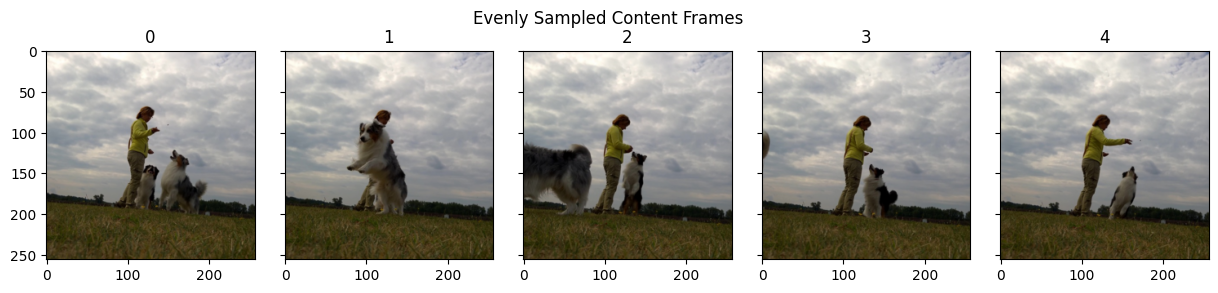

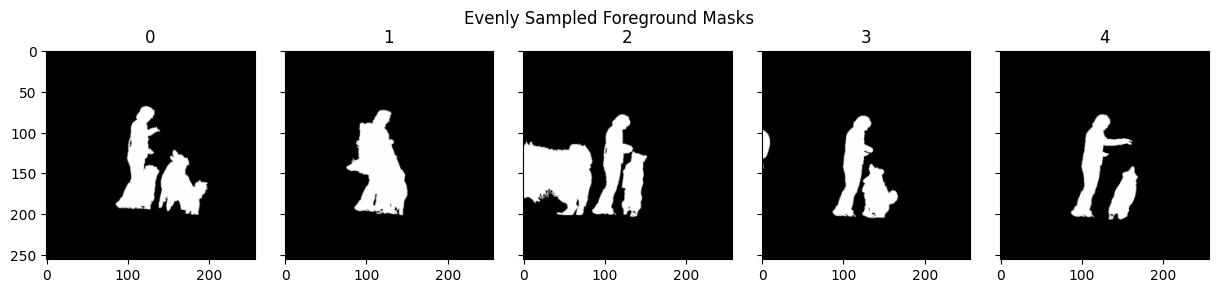

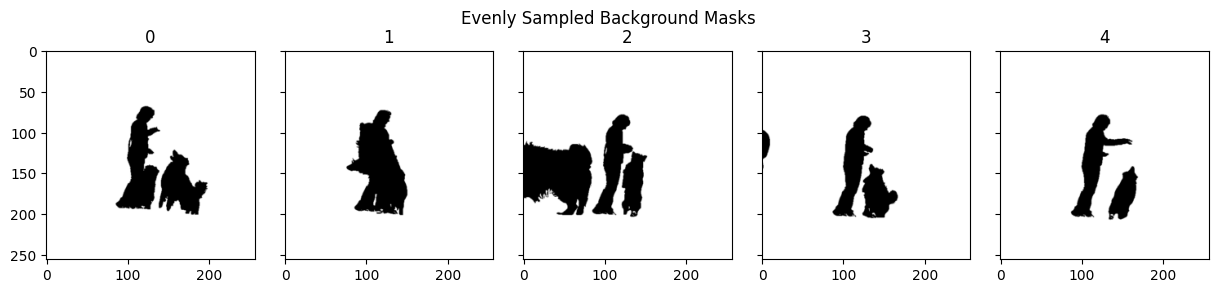

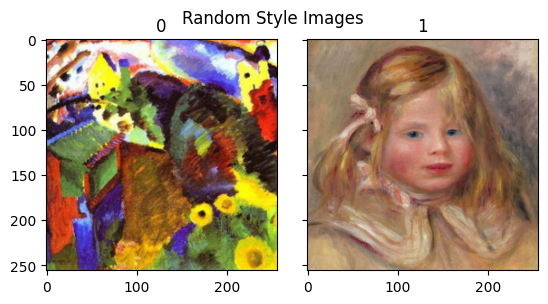

<ipython-input-8-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Epoch 0/1] [Batch 1/60] [Frame 0/10] [C loss: 88.200638, S loss: 197.418762, R loss: 7351.390137, Z loss: 0.546961, M loss: 0.153379, T loss: 0.211201, total loss: 570.704407]
[Epoch 0/1] [Batch 1/60] [Frame 1/10] [C loss: 89.482986, S loss: 198.537506, R loss: 7092.587891, Z loss: 0.560598, M loss: 0.151722, T loss: 0.001326, total loss: 357.028046]
[Epoch 0/1] [Batch 1/60] [Frame 2/10] [C loss: 90.842316, S loss: 196.513718, R loss: 7036.743164, Z loss: 0.583679, M loss: 0.152842, T loss: 0.001253, total loss: 354.187225]
[Epoch 0/1] [Batch 1/60] [Frame 3/10] [C loss: 83.454926, S loss: 198.271820, R loss: 7058.842773, Z loss: 0.610188, M loss: 0.141579, T loss: 0.001801, total loss: 356.405151]
[Epoch 0/1] [Batch 1/60] [Frame 4/10] [C loss: 80.456116, S loss: 198.414719, R loss: 7005.249023, Z loss: 0.623638, M loss: 0.126695, T loss: 0.001300, total loss: 354.735199]
[Epoch 0/1] [Batch 1/60] [Frame 5/10] [C loss: 79.547913, S loss: 199.974808, R loss: 6963.322266, Z loss: 0.628192

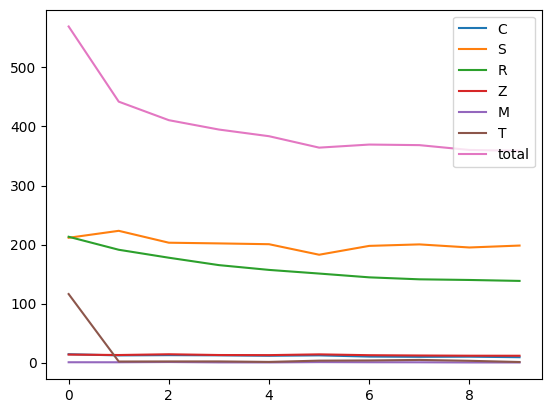

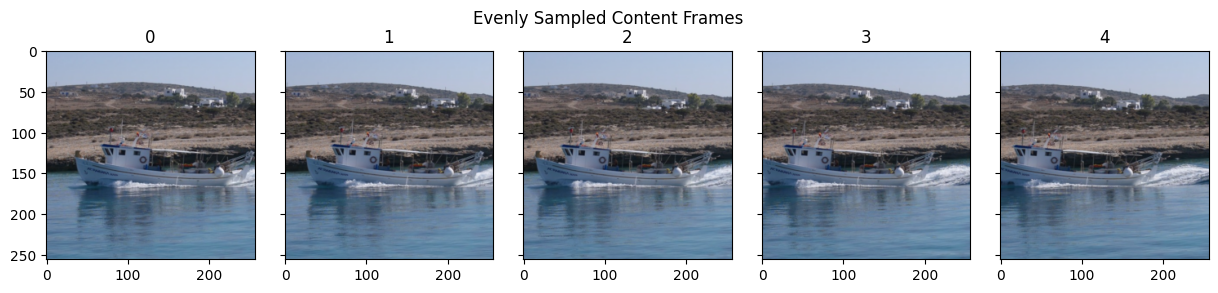

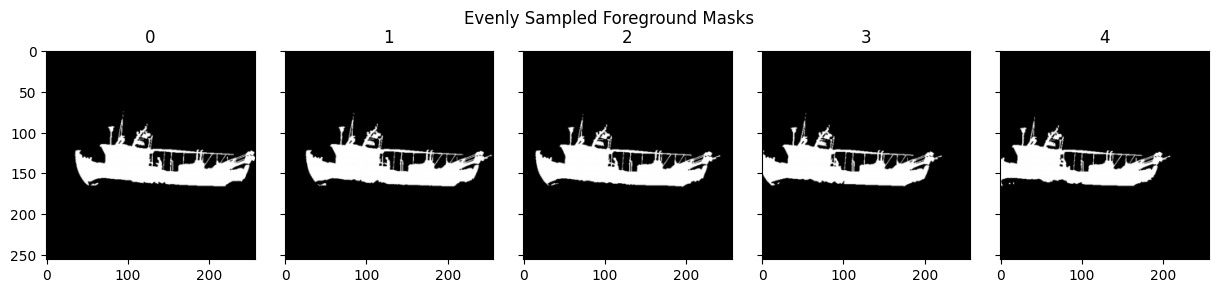

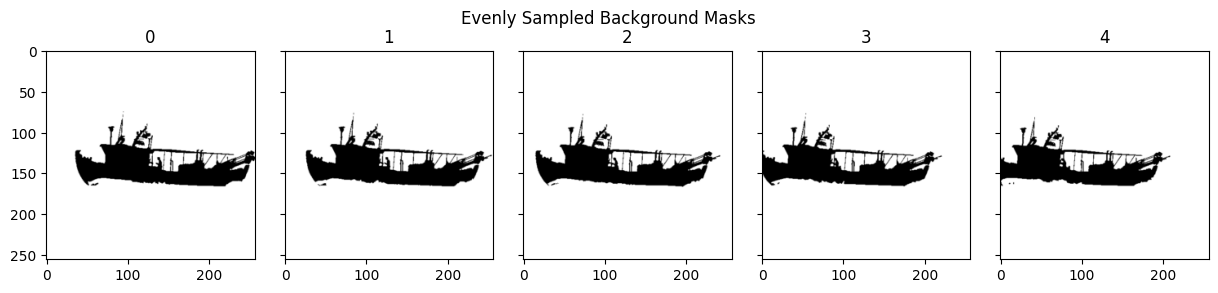

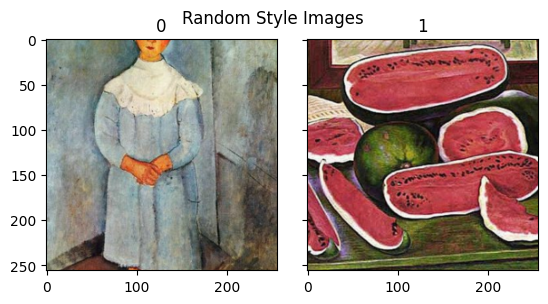

<ipython-input-8-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Epoch 0/1] [Batch 2/60] [Frame 0/10] [C loss: 141.942474, S loss: 65.795784, R loss: 6346.224609, Z loss: 1.539076, M loss: 0.422869, T loss: 0.131883, total loss: 356.302917]
[Epoch 0/1] [Batch 2/60] [Frame 1/10] [C loss: 139.140411, S loss: 70.154434, R loss: 6137.899414, Z loss: 1.503710, M loss: 0.430931, T loss: 0.021776, total loss: 245.794342]


KeyboardInterrupt: 

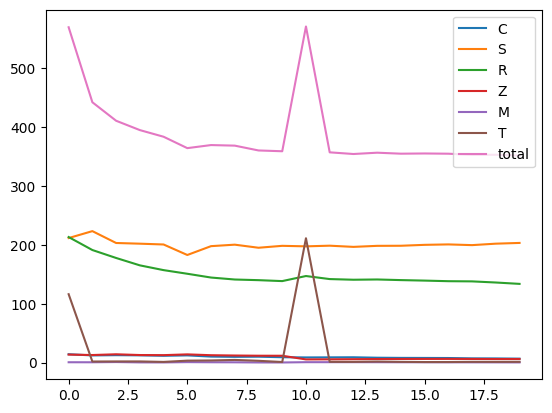

In [ ]:
# train with args
train(args)


## Evaluate validation metrics

In [26]:
def validate(args):
    cont_vids_path = args['cont_vids_path'] #/vids
    cont_mask_vids_path = args['cont_mask_vids_path'] #/mask_vids
    annotations_path_train = args['annotations_path_train'] #/annotations_path_train
    annotations_path_val = args['annotations_path_val'] #/annotations_path_val
    style_imgs_path = args['style_imgs_path'] #/style_images
    num_classes = args['num_classes'] #/num_classes
    batch_size = args['batch_size']
    checkpoint_path = args['checkpoint_path']
    output_path = args['output_path']
    log_interval = args['log_interval']
    ckpt_interval = args['ckpt_interval']

    # set dataset
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    val_dataset = MVSTDataset(cont_vids_path, cont_mask_vids_path, annotations_path_val, style_imgs_path, num_classes, img_size=256)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    flow_model = raft_small(weights=Raft_Small_Weights.DEFAULT, progress=False).to(device)
    flow_model = flow_model.eval()
    vgg_feature_extractor = get_VGG_feature_extractor().to(device)
    slice = Slice().to(device)
    apply = ApplyCoeffs().to(device)
    model = MaskedVideoStyleTransfer(slice, apply).to(device)
    if os.path.exists(checkpoints_root + '/ckpt_with_mask_0_49.pth'):
        checkpoint = torch.load(checkpoints_root + '/ckpt_with_mask_0_49.pth')
        model.load_state_dict(checkpoint)
        print('Loaded model ckpt_with_mask_0_49')
    model.eval()
    # optimizer = Adam(model.parameters(), lr=1e-4)
    L_loss = LaplacianRegularizer3D().to(device)
    epochs = 1
    batch_done = 0

    # track losses
    lam_c = 0.1
    lam_s = 1
    lam_r = 0.02
    lam_z = 1.5
    lam_m = 5
    lam_t = 1000
    c_loss_hist = []
    s_loss_hist = []
    r_loss_hist = []
    z_loss_hist = []
    m_loss_hist = []
    t_loss_hist = []
    loss_hist = []

    # training iteration
    for e in range(epochs):
        for batch_idx ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(val_loader):
            #cont_img is B x num_frames x 3 x 256 x 256
            # print(cont_imgs.shape, mask_img_lists.shape, style_img_lists.shape)
            bs = cont_imgs.shape[0]
            cpe_1_all = torch.randn(size=(bs, num_classes, 64, 256, 256), dtype=torch.float32).to(device)
            cpe_2_all = torch.randn(size=(bs, num_classes, 128, 128, 128), dtype=torch.float32).to(device)
            cpe_3_all = torch.randn(size=(bs, num_classes, 256, 64, 64), dtype=torch.float32).to(device)
            cpe_4_all = torch.randn(size=(bs, num_classes, 512, 32, 32), dtype=torch.float32).to(device)
            adap_1_all = torch.randn(size=(bs, num_classes, 8, 128, 128), dtype=torch.float32).to(device)
            adap_2_all = torch.randn(size=(bs, num_classes, 16, 64, 64), dtype=torch.float32).to(device)
            adap_3_all = torch.randn(size=(bs, num_classes, 32, 32, 32), dtype=torch.float32).to(device)
            output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
            mask_img_list_prev = torch.randn(size=(bs, num_classes, 3, 256, 256), dtype=torch.float32).to(device)

            for frame_idx in range(cont_imgs.shape[1]):
                cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
                mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
                style_img_list = style_img_lists.to(device)
                # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

                all_cont_feats = vgg_feature_extractor(cont_img)
                cont_feat = all_cont_feats['layer4']
                all_style_feats_list = [vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
                style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]
                # print('cpe1', cpe_1_all[:,:,0,0,0])
                output, blended_grid, bilateral_grid_list, soft_grid_mask_f, soft_grid_mask_b, bilateral_grid_list, guide, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all = model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

                all_out_feats = vgg_feature_extractor(output)
                loss_c_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                loss_s_agg = torch.tensor(0.0, dtype=torch.float32).to(device)
                for i in range(num_classes):
                    loss_c,loss_s  = content_and_style_loss(cont_feat, all_out_feats['layer4'], [all_style_feats_list[i][f'layer{j+1}'] for j in range(4)], [all_out_feats[f'layer{j+1}'] for j in range(4)])
                    loss_c_agg += loss_c
                    loss_s_agg += loss_s

                loss_r = L_loss(bilateral_grid_list[0]) + L_loss(bilateral_grid_list[1])
                loss_z = lumin_loss(guide, torchvision.transforms.Grayscale(num_output_channels=1)(cont_img))
                #TODO : update mask loss
                soft_grid_mask_f_ = soft_grid_mask_f.reshape(soft_grid_mask_f.shape[0],12,-1,soft_grid_mask_f.shape[-2],soft_grid_mask_f.shape[-1])
                # soft_grid_mask_b_ = soft_grid_mask_b.reshape(soft_grid_mask_b.shape[0],12,-1,soft_grid_mask_b.shape[-2],soft_grid_mask_b.shape[-1])
                reconstructed_mask_f = apply(slice(soft_grid_mask_f_, guide), guide)
                # reconstructed_mask_b = apply(slice(soft_grid_mask_b_, guide), guide)
                # loss_m = torch.tensor(0.0, dtype=torch.float32).to(device)
                # print(soft_grid_mask_.shape, guide.shape, mask_img_list.shape, reconstructed_mask.shape)
                # only wrt foreground mask
                loss_m = mask_loss(reconstructed_mask_f, mask_img_list[:, 0, :, :, :]) #+ mask_loss(reconstructed_mask_b, mask_img_list[:, 1, :, :, :])
                list_of_flows = flow_model(output, output_prev) #last one in the list is the most accurate

                loss_t = temporal_loss(list_of_flows[-1], output, output_prev)

                total_loss = lam_c * loss_c_agg + lam_s * loss_s_agg + lam_r * loss_r + lam_z * loss_z + lam_m * loss_m + lam_t * loss_t

                c_loss_hist.append(loss_c_agg.item())
                s_loss_hist.append(loss_s_agg.item())
                r_loss_hist.append(loss_r.item())
                z_loss_hist.append(loss_z.item())
                m_loss_hist.append(loss_m.item())
                t_loss_hist.append(loss_t.item())
                loss_hist.append(total_loss.item())

                output_prev = output.clone().detach()
                mask_img_list_prev = mask_img_list.clone().detach()

                # Print log
                print(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Frame %d/%d] [C loss: %f, S loss: %f, R loss: %f, Z loss: %f, M loss: %f, T loss: %f, total loss: %f]"
                    % (
                        e,
                        epochs,
                        batch_idx,
                        len(val_loader),
                        frame_idx,
                        cont_imgs.shape[1],
                        loss_c_agg.item(),
                        loss_s_agg.item(),
                        loss_r.item(),
                        loss_z.item(),
                        loss_m.item(),
                        loss_t.item(),
                        total_loss.item(),
                    )
                )
            batch_done += 1
    print(f'[Validation] Mean losses : C : {np.mean(c_loss_hist)}, S : {np.mean(s_loss_hist)}, R : {np.mean(r_loss_hist)}, Z : {np.mean(z_loss_hist)}, M : {np.mean(m_loss_hist)}, T : {np.mean(t_loss_hist)}, C : {np.mean(loss_hist)}')
    plot_all_losses([c_loss_hist, c_loss_hist, c_loss_hist, c_loss_hist, c_loss_hist, c_loss_hist, c_loss_hist], output_path, epochs, True)
    return

In [27]:
validate(args)

Using device: cpu


Downloading: "https://download.pytorch.org/models/raft_small_C_T_V2-01064c6d.pth" to /root/.cache/torch/hub/checkpoints/raft_small_C_T_V2-01064c6d.pth


Loaded model ckpt_with_mask_0_49


<ipython-input-9-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[Epoch 0/1] [Batch 0/8] [Frame 0/10] [C loss: 149.026093, S loss: 155.716415, R loss: 650.161438, Z loss: 0.624066, M loss: 0.271129, T loss: 0.122405, total loss: 308.319458]
[Epoch 0/1] [Batch 0/8] [Frame 1/10] [C loss: 143.337067, S loss: 162.656006, R loss: 703.186523, Z loss: 0.641774, M loss: 0.233032, T loss: 0.004692, total loss: 197.873138]
[Epoch 0/1] [Batch 0/8] [Frame 2/10] [C loss: 150.300903, S loss: 162.801666, R loss: 703.029236, Z loss: 0.697811, M loss: 0.278679, T loss: 0.005382, total loss: 199.714523]
[Epoch 0/1] [Batch 0/8] [Frame 3/10] [C loss: 138.508362, S loss: 166.481506, R loss: 689.961060, Z loss: 0.752999, M loss: 0.259817, T loss: 0.005155, total loss: 201.714966]
[Epoch 0/1] [Batch 0/8] [Frame 4/10] [C loss: 142.110718, S loss: 164.805573, R loss: 704.304199, Z loss: 0.777125, M loss: 0.242150, T loss: 0.006102, total loss: 201.581680]
[Epoch 0/1] [Batch 0/8] [Frame 5/10] [C loss: 141.307800, S loss: 165.162720, R loss: 709.420166, Z loss: 0.808387, M lo

KeyboardInterrupt: 

# Visualize results

Using device: cpu
Loaded model ckpt_with_mask_0_49


<ipython-input-9-96658158698e>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x : torch.tensor((x > 0), dtype=torch.float32)),


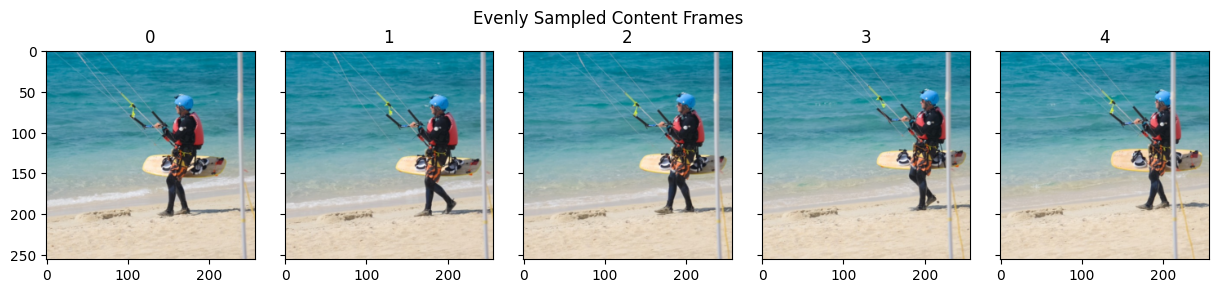

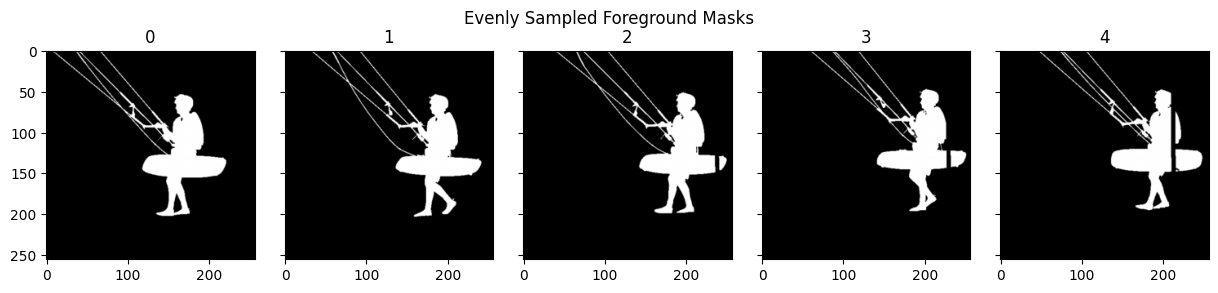

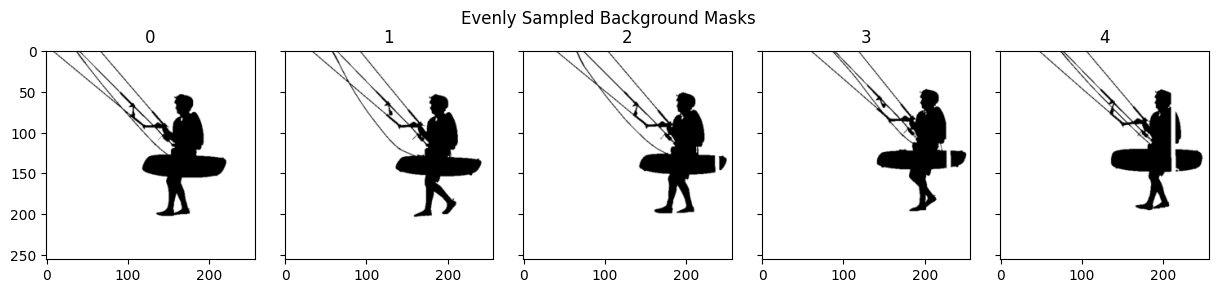

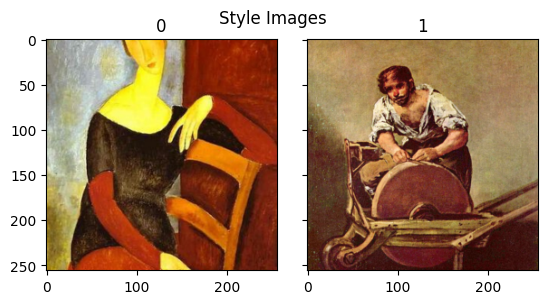

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


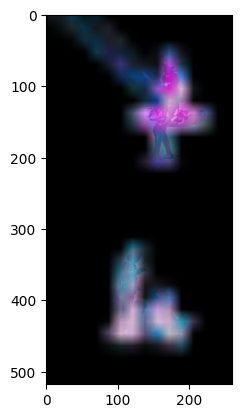

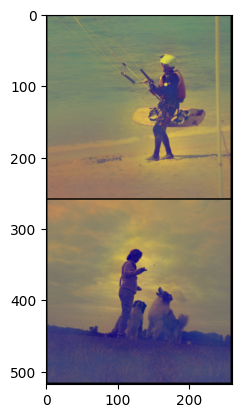

out min max :  tensor(-0.4681, grad_fn=<MinBackward1>) tensor(0.6183, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


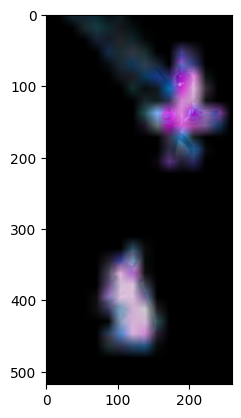

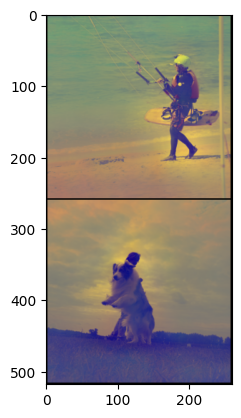

out min max :  tensor(-0.4522, grad_fn=<MinBackward1>) tensor(0.5295, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


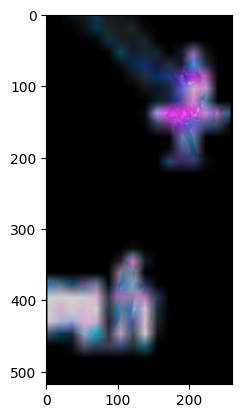

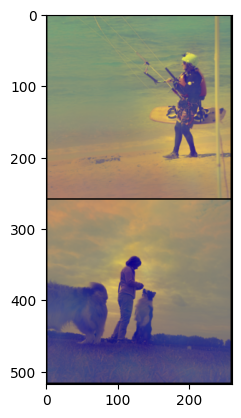

out min max :  tensor(-0.4636, grad_fn=<MinBackward1>) tensor(0.5212, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


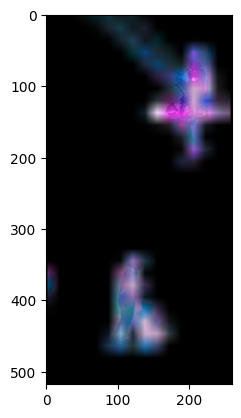

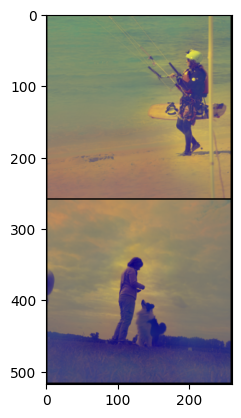

out min max :  tensor(-0.4526, grad_fn=<MinBackward1>) tensor(0.5714, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


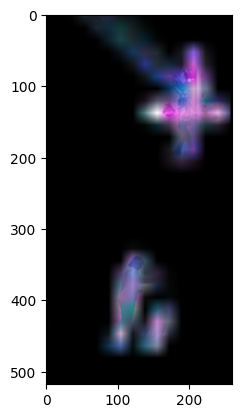

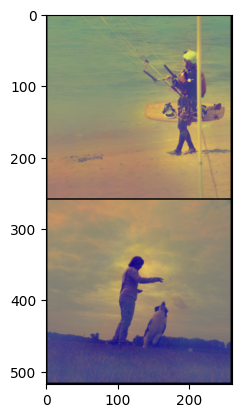

out min max :  tensor(-0.4739, grad_fn=<MinBackward1>) tensor(0.5272, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


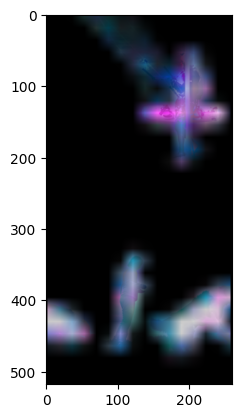

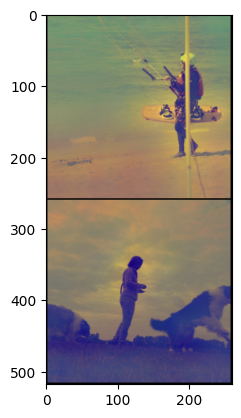

out min max :  tensor(-0.4493, grad_fn=<MinBackward1>) tensor(0.5645, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


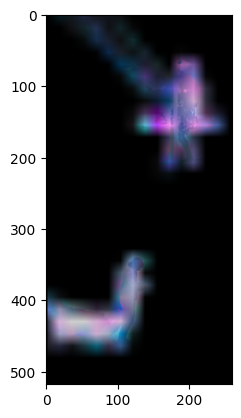

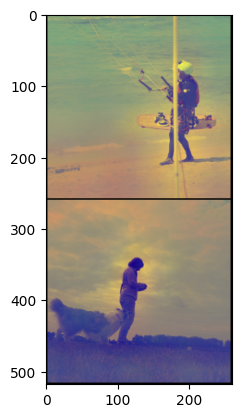

out min max :  tensor(-0.4787, grad_fn=<MinBackward1>) tensor(0.4961, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


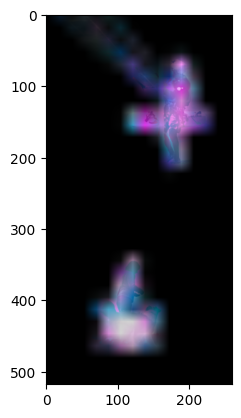

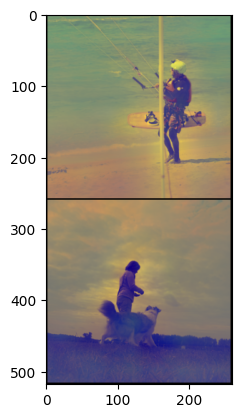

out min max :  tensor(-0.4648, grad_fn=<MinBackward1>) tensor(0.5618, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


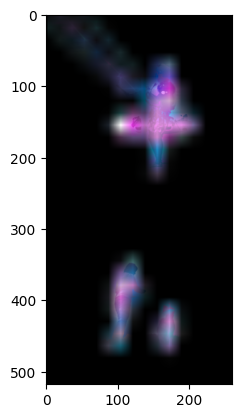

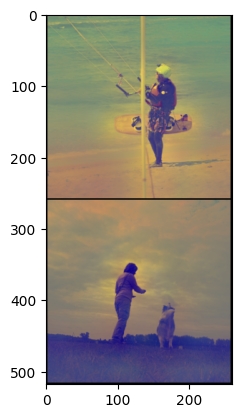

out min max :  tensor(-0.4641, grad_fn=<MinBackward1>) tensor(0.5538, grad_fn=<MaxBackward1>)
torch.Size([3, 518, 260]) tensor(0.) tensor(1.)


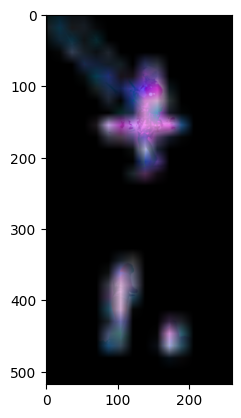

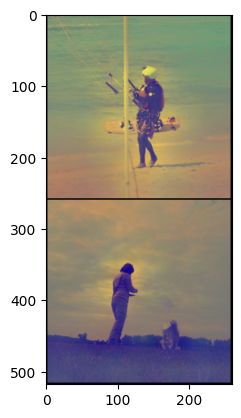

out min max :  tensor(-0.4921, grad_fn=<MinBackward1>) tensor(0.5762, grad_fn=<MaxBackward1>)
torch.Size([20, 3, 256, 256])
denormalized out min max :  88 159


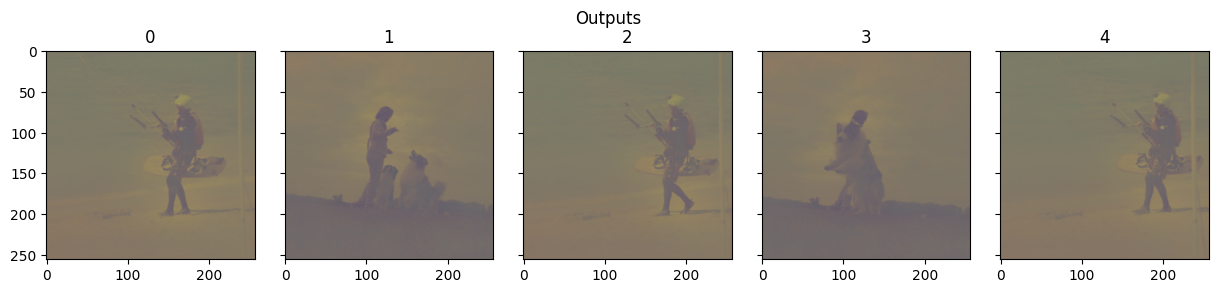

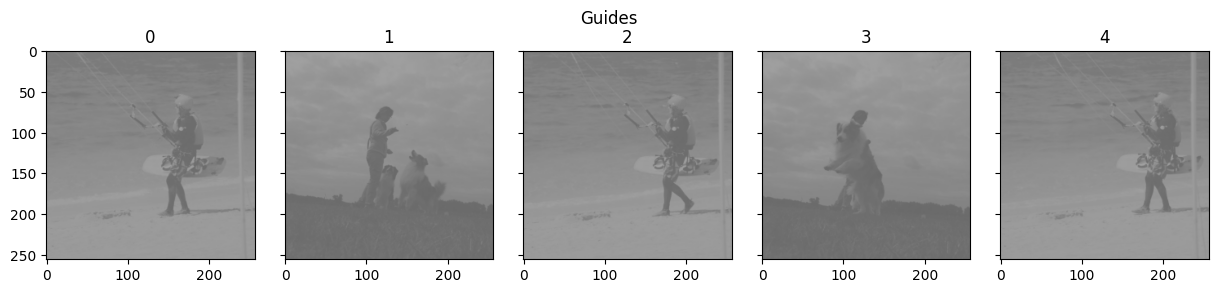

In [18]:
from torchvision.utils import save_image,make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

infer_vgg_feature_extractor = get_VGG_feature_extractor().to(device)
infer_slice = Slice().to(device)
infer_apply = ApplyCoeffs().to(device)
infer_model = MaskedVideoStyleTransfer(infer_slice, infer_apply).to(device)
if os.path.exists(checkpoints_root + '/ckpt_with_mask_0_49.pth'):
    checkpoint = torch.load(checkpoints_root + '/ckpt_with_mask_0_49.pth')
    infer_model.load_state_dict(checkpoint)
    print('Loaded model ckpt_with_mask_0_49')
infer_model.eval()
count = 0
random_idx = np.random.randint(5)
for i ,(cont_imgs, mask_img_lists, style_img_lists) in enumerate(train_loader):
    if i < random_idx:
        continue
    #cont_img is B x num_frames x 3 x 256 x 256
    bs = cont_imgs.shape[0]
    plot_video(rows=1, cols=5, frame_list=denormalize(cont_imgs[0]), plot_width=15., plot_height=3.,
               title='Evenly Sampled Content Frames')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][0] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Foreground Masks')
    plot_video(rows=1, cols=5, frame_list=(mask_img_lists[0][1] * 255).type(torch.uint8).permute(0,2,3,1).numpy(), plot_width=15., plot_height=3.,
               title='Evenly Sampled Background Masks')
    plot_video(rows=1, cols=2, frame_list=denormalize(style_img_lists[0]), plot_width=15., plot_height=3.,
               title='Style Images')

    cpe_1_all = torch.randn(size=(bs, num_classes, 64, 256, 256), dtype=torch.float32).to(device)
    cpe_2_all = torch.randn(size=(bs, num_classes, 128, 128, 128), dtype=torch.float32).to(device)
    cpe_3_all = torch.randn(size=(bs, num_classes, 256, 64, 64), dtype=torch.float32).to(device)
    cpe_4_all = torch.randn(size=(bs, num_classes, 512, 32, 32), dtype=torch.float32).to(device)
    adap_1_all = torch.randn(size=(bs, num_classes, 8, 128, 128), dtype=torch.float32).to(device)
    adap_2_all = torch.randn(size=(bs, num_classes, 16, 64, 64), dtype=torch.float32).to(device)
    adap_3_all = torch.randn(size=(bs, num_classes, 32, 32, 32), dtype=torch.float32).to(device)
    output_prev = torch.randn(size=(bs, 3, 256, 256), dtype=torch.float32).to(device)
    mask_img_list_prev = torch.randn(size=(bs, num_classes, 3, 256, 256), dtype=torch.float32).to(device)

    output_frames = []
    guides = []
    for frame_idx in range(cont_imgs.shape[1]):
        cont_img = cont_imgs[:,frame_idx,:,:,:].to(device)
        mask_img_list = mask_img_lists[:,:,frame_idx,:,:,:].to(device)
        style_img_list = style_img_lists.to(device)
        # print('training: ', i, cont_img.shape, (mask_img_list.shape), (style_img_list.shape))

        all_cont_feats = infer_vgg_feature_extractor(cont_img)
        cont_feat = all_cont_feats['layer4']
        all_style_feats_list = [infer_vgg_feature_extractor(style_img_list[:,i,:,:,:]) for i in range(num_classes)]
        style_feat_list = [all_style_feats_list[i]['layer4'] for i in range(num_classes)]

        output, blended_grid, bilateral_grid_list, soft_grid_mask_f, soft_grid_mask_b, bilateral_grid_list, guide, cpe_1_all_, cpe_2_all_, cpe_3_all_, cpe_4_all_, adap_1_all_, adap_2_all_, adap_3_all_ = infer_model(cont_img, mask_img_list, style_img_list, mask_img_list_prev, cpe_1_all, cpe_2_all, cpe_3_all, cpe_4_all, adap_1_all, adap_2_all, adap_3_all)

        output_prev = output.clone().detach()
        mask_img_list_prev = mask_img_list.clone().detach()

        soft_grid_mask_f_ = soft_grid_mask_f.reshape(soft_grid_mask_f.shape[0],12,-1,soft_grid_mask_f.shape[-2],soft_grid_mask_f.shape[-1])
        # soft_grid_mask_b_ = soft_grid_mask_b.reshape(soft_grid_mask_b.shape[0],12,-1,soft_grid_mask_b.shape[-2],soft_grid_mask_b.shape[-1])
        reconstructed_mask_f = infer_apply(infer_slice(soft_grid_mask_f_, guide), guide)
        # reconstructed_mask_b = infer_apply(infer_slice(soft_grid_mask_b_, guide), guide)

        grid_f = make_grid(reconstructed_mask_f, nrow=1, normalize = True)
        # grid_b = make_grid(reconstructed_mask_b, nrow=1, normalize = True)
        grid_out = make_grid(output, nrow=1, normalize = True)
        # print(grid_f.shape, grid_f.min(), grid_f.max())
        print(grid_f.shape, grid_f.min(), grid_f.max())
        plt.imshow(grid_f.cpu().detach().permute(1,2,0).numpy())
        plt.show()
        # plt.imshow(grid_b.cpu().detach().permute(1,2,0).numpy())
        # plt.show()
        plt.imshow(grid_out.cpu().detach().permute(1,2,0).numpy())
        plt.show()
        print('out min max : ', output.min(), output.max())
        output_frames.append(output)
        guides.append(guide.detach().repeat(1, 3,1,1))
        # break
    output_frames_tensor = torch.cat(output_frames, dim=0).to(device)
    torch.save(output_frames_tensor, 'out_frames.pt')
    print(output_frames_tensor.shape)
    denormalized_output = denormalize(output_frames_tensor.cpu())
    print('denormalized out min max : ', np.min(denormalized_output), np.max(denormalized_output))
    plot_video(rows=1, cols=5, frame_list=denormalized_output, plot_width=15., plot_height=3.,
               title='Outputs')
    plot_video(rows=1, cols=5, frame_list=(torch.cat(guides, dim = 0) * 255).type(torch.uint8).permute(0,2,3,1).cpu().numpy(), plot_width=15., plot_height=3.,
               title='Guides')
    count += 1
    if count > 0:
        break


torch.Size([2, 2, 3, 256, 256])
torch.Size([256, 256])
tensor(0.) tensor(3.0000)


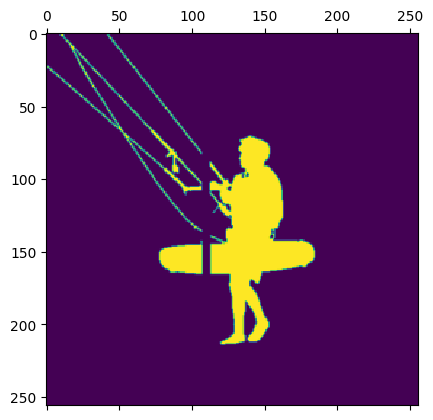

torch.Size([2, 96, 16, 16])
torch.Size([16, 16])
tensor(1.) tensor(87.)


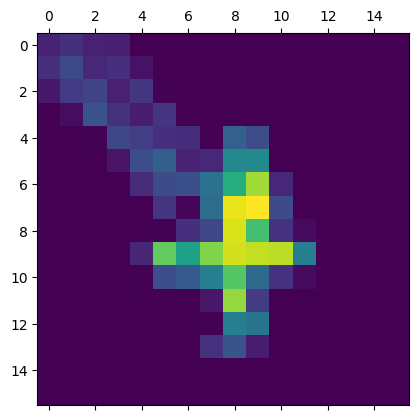

torch.Size([16, 16])
tensor(0.9942, grad_fn=<MinBackward1>) tensor(2.3242, grad_fn=<MaxBackward1>)



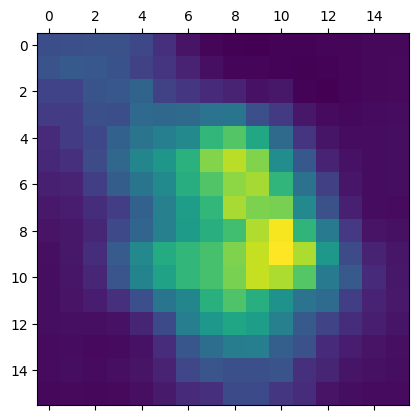

torch.Size([16, 16])
tensor(0.8579, grad_fn=<MinBackward1>) tensor(2.5401, grad_fn=<MaxBackward1>)


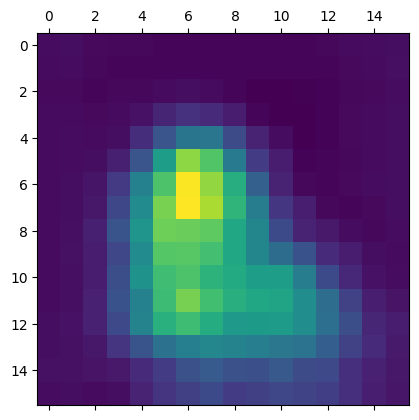

torch.Size([2, 96, 16, 16])
torch.Size([16, 16])
tensor(0.6414, grad_fn=<MinBackward1>) tensor(2.2271, grad_fn=<MaxBackward1>)


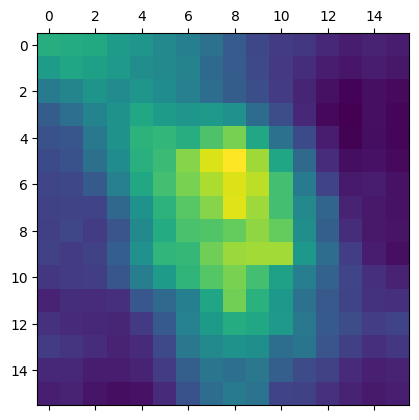

In [24]:
print(mask_img_list.shape)
temp = torch.sum(torch.squeeze(mask_img_list)[0][0], dim=0)
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())
plt.show()

print(soft_grid_mask_f.shape)
temp = torch.sum(torch.squeeze(soft_grid_mask_f)[0], dim=0)
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())
plt.show()

temp = torch.sum(torch.squeeze(bilateral_grid_list[0][0]), dim=0)
print(temp.shape)
print(temp.min(), temp.max())
print()
plt.matshow(temp.detach().cpu().numpy())
plt.show()

temp = torch.sum(torch.squeeze(bilateral_grid_list[0][1]), dim=0)
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())
plt.show()
# print(soft_grid_mask_b.shape)
# temp = torch.sum(torch.squeeze(soft_grid_mask_b), dim=0)
# print(temp.shape)
# print(temp.min(), temp.max())
# plt.matshow(temp.detach().cpu().numpy())

print(blended_grid.shape)
temp = torch.sum(torch.squeeze(blended_grid[0]), dim=0)
print(temp.shape)
print(temp.min(), temp.max())
plt.matshow(temp.detach().cpu().numpy())